In [19]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

# Assignment 2

## 1. Image Stitching 

This problem will walk you through the process of image stitching by detecting and matching corners, and estimating the homography based the matches.

### 1a. Detect Keypoints and Calculate Descriptors (10 points)

Load the sample image pair.

In [20]:
img1 = cv2.imread('data/graff1.png')
img2 = cv2.imread('data/graff2.png')

Since we have implemented the Harris corner detector from scratch in the weekly notebooks, in this problem we will use OpenCV to detect corners and get their descriptors. In the cell below, detect feature points and calculate their descriptors in both images using OpenCV's ORB detector and descriptor.

In [21]:
orb = cv2.ORB_create()
kps1, des1 = orb.detectAndCompute(img1, None)# Done
kps2, des2 = orb.detectAndCompute(img2, None)# Done

Visualize locations of detected features. You should see the following images (also 1.png):

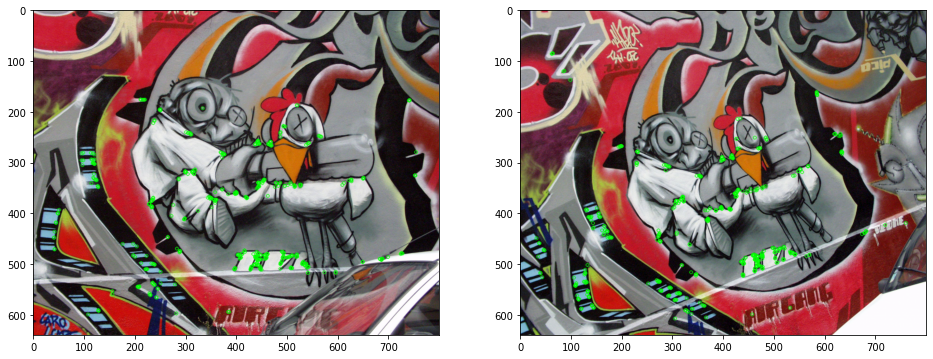


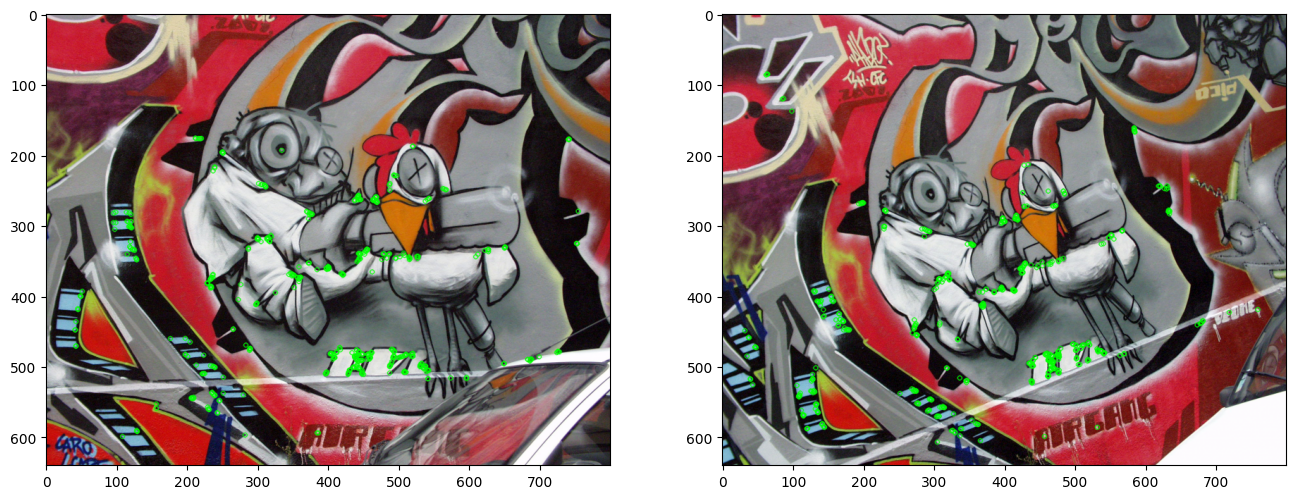

In [22]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

### 1b. Match Keypoints (10 points)

Check out OpenCV's online docs and answer the following question:
- What attributes does each detected keypoint have? Briefly explain what they represent.

In [ ]:
# Type your answer below:
# keypoints attributes:
# 1. pt: coordinates of the keypoint [x,y]
# 2. size: diameter of the meaningful keypoint neighborhood
# 3. angle: computed orientation of the keypoint (-1 if not applicable); it's in [0,360) degrees and measured relative to image coordinate system (y-axis is directed downward), i.e in clockwise.
# 4. response: the response by which the most strong keypoints have been selected. Can be used for further sorting or subsampling.
# 5. octave: octave (pyramid layer) from which the keypoint has been extracted.
# 6. class_id: object class (if the keypoints need to be clustered by an object they belong to).

- What is the "apparent" size of each descriptor and what data type does it have? (You can easily find the answer by printing the `shape` and `dtype` of a descriptor.) The ORB [paper](https://ieeexplore.ieee.org/document/6126544) says "*we propose a very fast **binary** descriptor based on BRIEF, called ORB*." Based on this, what is the actual length of each binary descriptor?

In [9]:
print(f'descriptor data type: {des2.dtype}')
print(f'descriptor shape: {des2.shape}')
# Type your answer below:
# The data type of each descriptor is unit8 and its shape is 500 * 32. The actual length of the descriptor is 8192 (32 * 256) bits.

descriptor data type: uint8
descriptor shape: (500, 32)


- Given two ORB descriptors, how should you measure their distance?

In [ ]:
# Type your answer below:
# I will use the descriptor of one feature in the first ORB to match all other features in second ORB using hamming distance metrics and find closest one as result.

Using `cv2.BFMatcher`, calculate the matching between the two lists of keypoints. Be sure to use the correct distance measurement. Also, set `crossCheck=True` when creating the matcher. After you get the matches, sort them by distance and call `cv2.drawMatches()` to display the 100 closest matches. You should see the following images (also found in 2.png):

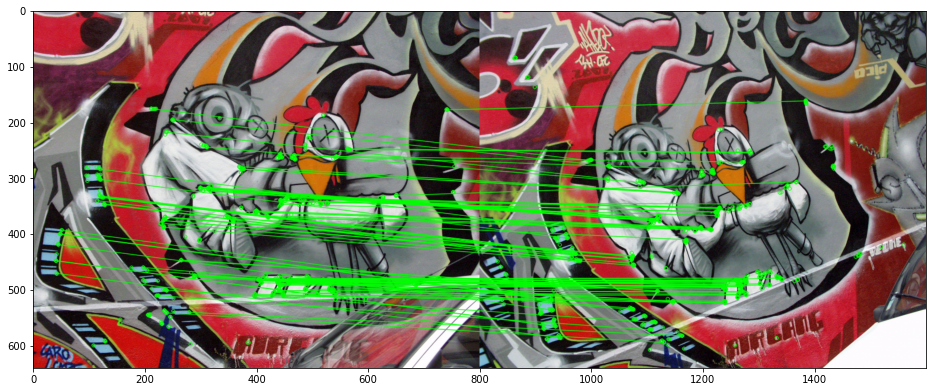


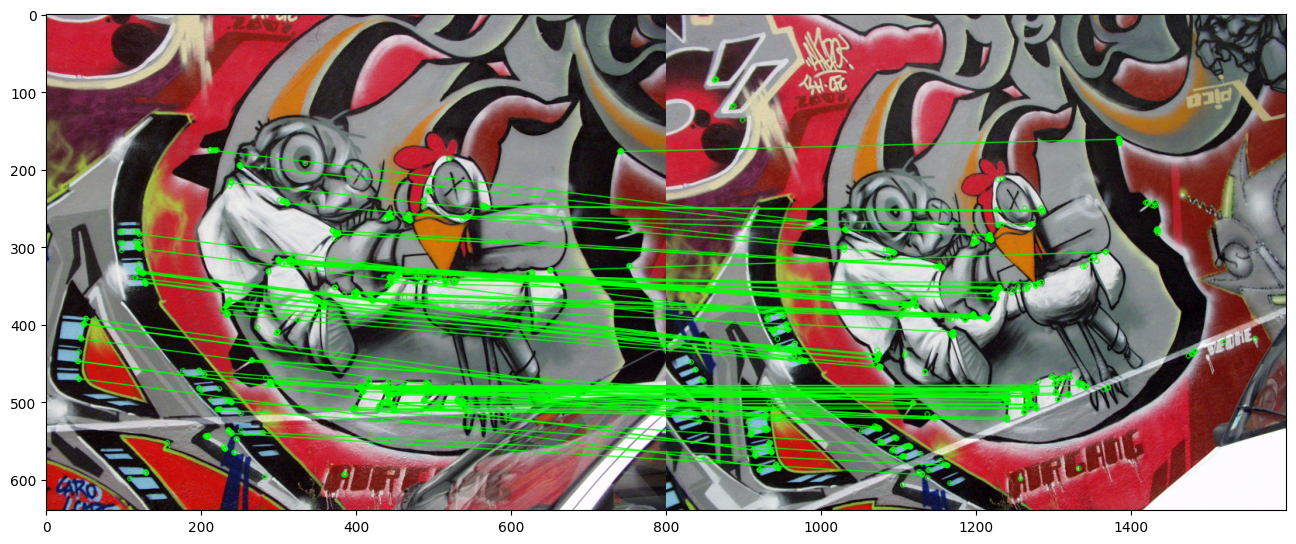

In [23]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1, des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)# Done
match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:100], None,
    matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

### 1c. Calculate Homography Between Matching Keypoints (20 points)

Implement the following function to calculate the projective transformation that maps a list of (x, y) coordinates `pts1` to the list of matching coordinates `pts2`. The return value is a 3x3 array representing the transformation matrix. You don't need to worry about there being outlier matches between `pts1` and `pts2` here.

You should implement this from from scratch and may **NOT** simply call functions from OpenCV or other libraries to solve this for you. 

In [12]:
def get_homography(pts1, pts2):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    # Done
    A = []
    for i in range(len(pts1)):
        p1 = pts1[i]
        p2 = pts2[i]
        Ai1 = [p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]]
        Ai2 = [0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]]  
        A.append(Ai1)
        A.append(Ai2)
    
    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    t = vh[-1, :].reshape((3, 3))
    return t


# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]
t = get_homography(pts1, pts2)
print(t)

[[ 5.62558185e-03  1.98911992e-03 -2.67262500e-01]
 [-1.11606724e-03  5.92492523e-03  9.63565713e-01]
 [ 1.32247912e-06 -1.23451088e-07  6.31819957e-03]]


### 1d. Estimate Affine Transformation Between Images Using RANSAC (30 points)

Implement the following function to estimate the homography between two images given keypoints and matches. There may be outliers in the keypoint matches and you should implement the RANSAC algorithm to reject them. You should implement RANSAC from scratch and may **NOT** simply call the corresponding functions in OpenCV or any other existing libraries.

# Comments: due to the random selection of matches, the final results of transformation matrix may not be good. I suggest you can run this cell several times and you will get matched results.

In [28]:
import random
import math
def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
    n_samples, n_trials, inlier_thresh):
      """Estimate the transformation between two matching lists of keypoints 
      using RANSAC.
      
      Args:
      - kps1: A list of `cv2.KeyPoint` objects.
      - kps2: A list of `cv2.KeyPoint` objects.
      - matches: A list of `cv2.DMatch` objects representing the matches
            between `kps1` and `kps2`.
      - transform_func: Function used to estimate the transformation given
            matching points.
      - n_samples: The number of samples in each RANSAC trial.
      - n_trials: The total number of RANSAC trials.
      - inlier_thresh: The threshold used to determine whether a match is an
            inlier or not.
      
      Returns:
      - transform: The 3x3 transformation matrix that maps kps1 to kps2.
      - mask: A list of Boolean values representing whether the corresponding
            match is an inlier or not.
      """
      # Done
      # 1. randomly choose n_samples
      max_inlier = -np.Inf
      temp_matches = matches
      for i in range(n_trials):
            temp_mask = [0] * len(matches)
            random.seed(4)
            random.shuffle(temp_matches)
            samples = temp_matches[:n_samples]
            # 2. Fit a homography model
            pts1 = []
            pts2 = []
            for j in range(n_samples):
                  (x1, y1) = kps1[samples[j].queryIdx].pt
                  (x2, y2) = kps2[samples[j].trainIdx].pt
                  pts1.append([x1, y1])
                  pts2.append([x2, y2])
            
            # get transformation matrix H
            H = transform_func(pts1, pts2)
            
            # check number of inlier
            inlier_count = 0
            for k in range(n_samples):
                  p1 = [pts1[k][0], pts1[k][1], 1.0]
                  p2 = pts2[k]
                  p2_prime = np.dot(H, p1) 
                  p2_estim = [p2_prime[0]/p2_prime[2], p2_prime[1]/p2_prime[2]]
                  if math.dist(p2, p2_estim) < inlier_thresh:
                        inlier_count += 1
                        temp_mask[matches.index(samples[k])] = 1
            
            # check the maximum number of inliers
            if inlier_count > max_inlier:
                  max_inlier = inlier_count
                  mask = temp_mask
      
      inlier_matches = np.array(matches)[np.array(mask) == 1]
      pts1 = []
      pts2 = []
      for mat in inlier_matches:
            (x1, y1) = kps1[mat.queryIdx].pt
            (x2, y2) = kps2[mat.trainIdx].pt
            pts1.append([x1, y1])
            pts2.append([x2, y2])
      
      transform = transform_func(pts1, pts2)
      return transform, mask

transform, mask = estimate_transformation_ransac(kps1, kps2, matches, get_homography, 
                                                 30, 5000, 0.5)# Done
print(f"The transformation matrix:\n{transform}.")
print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")

The transformation matrix:
[[ 5.39912197e-03  1.89204957e-03 -2.30103343e-01]
 [-1.15572368e-03  5.70071589e-03  9.73112383e-01]
 [ 1.14052647e-06 -1.50369061e-07  6.17871420e-03]].
12 out of 281 matches are inliers.


The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images. You should see the following image (also found 3.png):

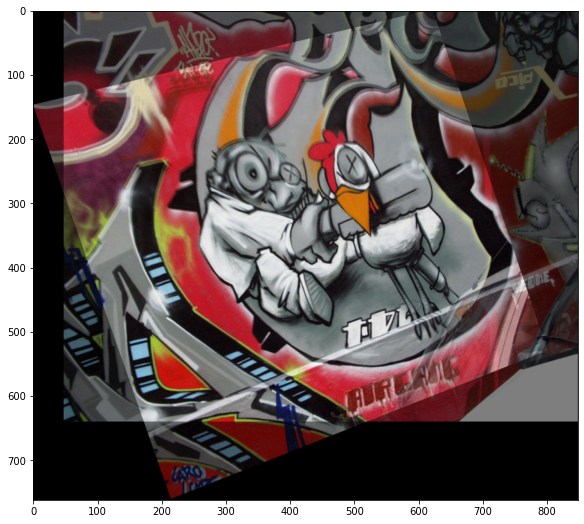

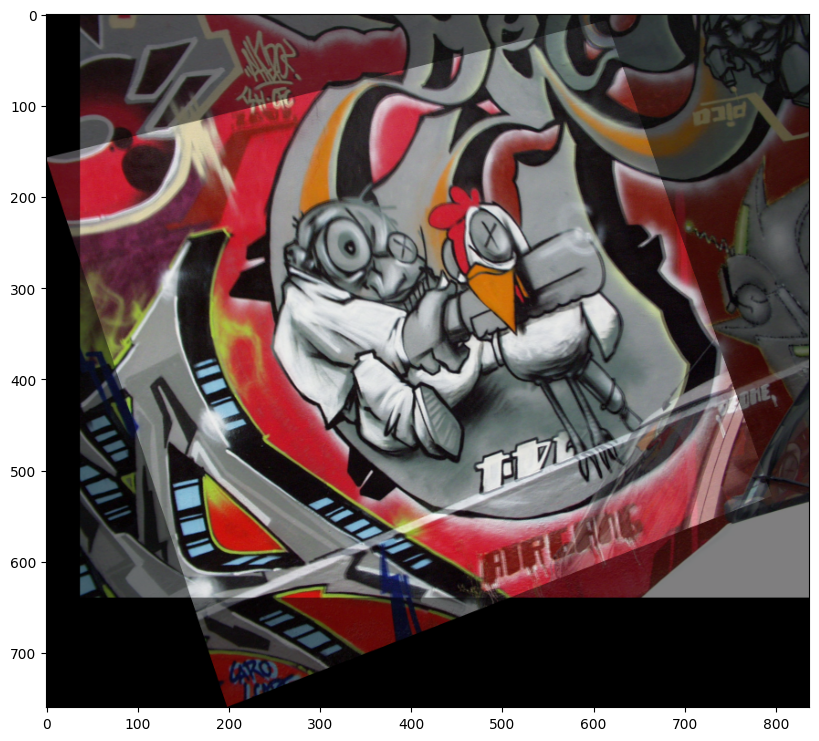

In [29]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l,  0))
    r = np.max((r, w2))
    t = np.min((t,  0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Disparity Map (30 points)

In this problem you will find dense correspondences between the stereo image pair below and calculate the disparity map. This will be done by doing template matching between image windows.

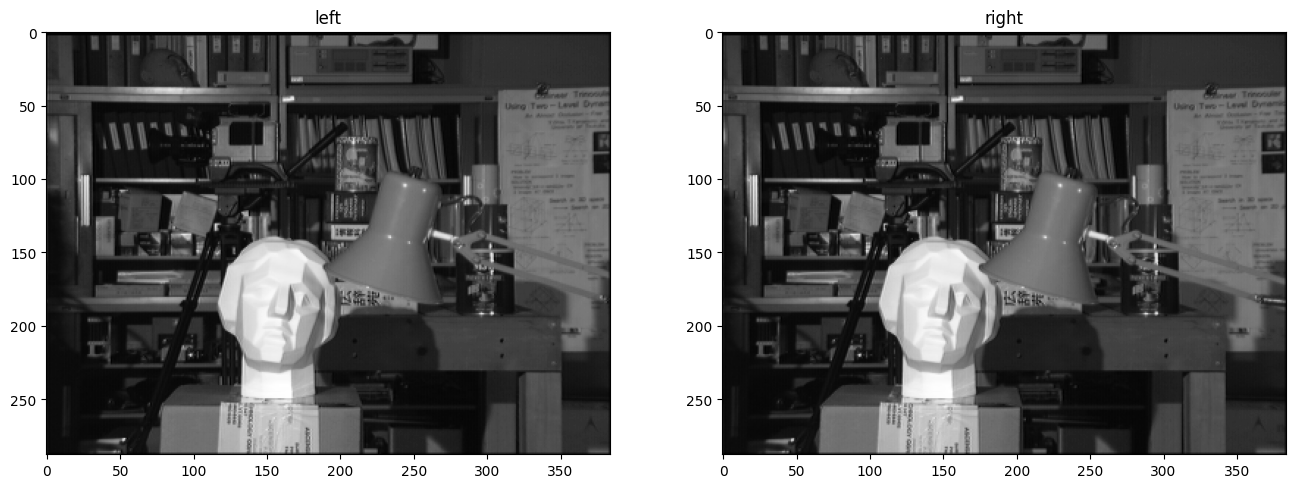

In [17]:
img1 = cv2.imread('data/left.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY) / 255.

img2 = cv2.imread('data/right.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY) / 255.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray')
ax1.set_title('left')
ax2.imshow(img2, cmap='gray')
ax2.set_title('right')
plt.show()

In the cell below, implement a system to calculate the disparity map and visualize the results. You can assume that the camera angle of the images are already rectified, so the epipolar lines are all horizontal. Use SSD as the similarity measure between windows. Set the window size to `7` and the maximum disparity value to `40`.

A naive implementation could take several minutes to run and you should avoid that. Recall from the lectures that we covered a more efficient implementation. You should see the following image (also found in 4.png):

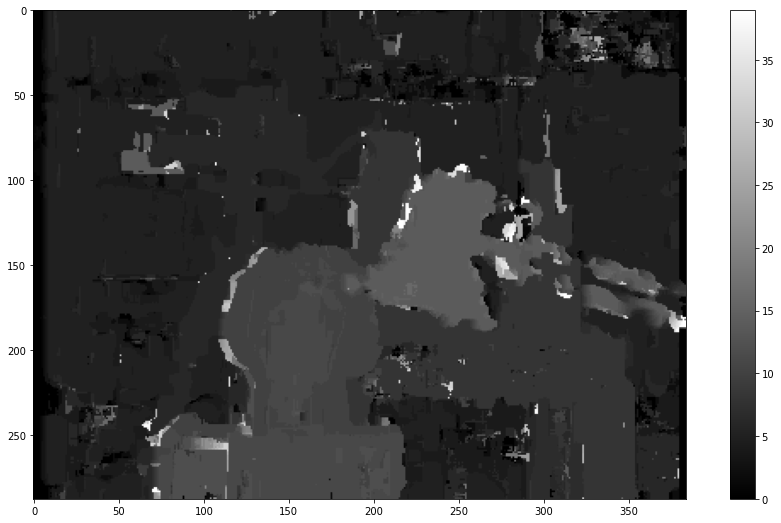


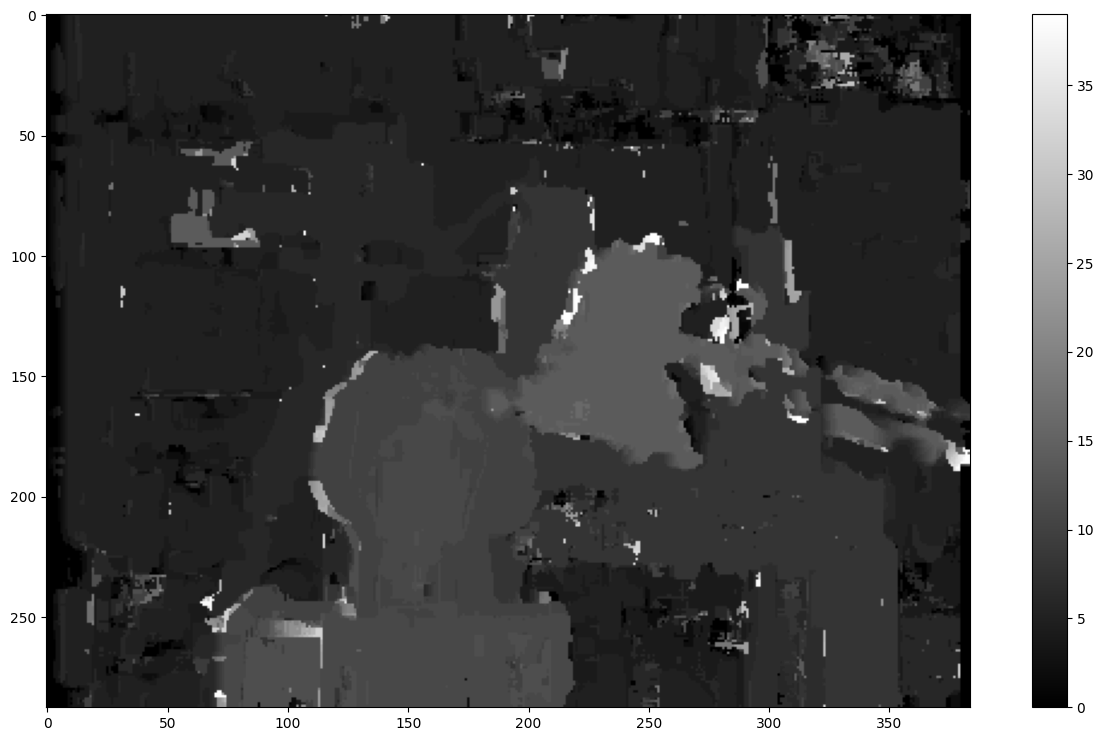

In [18]:
from scipy.signal import convolve2d
from numpy.linalg import norm 

assert img1.shape == img2.shape
h, w = img1.shape

dmin, dmax = 0, 40  # disparity search range
s = 7  # windows size

# Done
best = -np.ones((h, w))
disp = np.zeros((h, w))
kernel = np.ones((s,s)) / (s*s)


for i in range(dmin, dmax):
        # get similarity of overlap area
        prod = -((img1[:, i:w] - img2[:, :w-i])**2)
        # get the cross correlation score
        cc = convolve2d(prod, kernel, mode='same')
        # pad cc to (h, w) dimensions
        cc_pad = -10000 * np.ones((h, w))
        cc_pad[:, i:w] = cc
        # compute to find best score (correspondence)
        better = (cc_pad > best)
        # update disparity and best score
        disp = better * i + (1 - better) * disp
        best = better * cc_pad + (1 - better) * best

plt.imshow(disp, cmap='gray')
plt.colorbar()
plt.show()